In [29]:
import json
import os
import pickle
import collections
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import scipy.misc
from scipy import ndimage
from sklearn.externals import joblib
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model, load_model, model_from_json
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import CustomObjectScope

In [2]:
def get_files_paths(folder):
    files = os.listdir(folder)
    files.sort()
    files = ["{}/{}".format(folder, file) for file in files if not file.startswith(".")]
    return files

In [3]:
models_json = get_files_paths("trained_model_files/symbols/JSON")
print("\n".join("{}: {}".format(*k) for k in enumerate(models_json)))

0: trained_model_files/symbols/JSON/TMS_v39_DI_3WAYS_30EP_98.8_.json
1: trained_model_files/symbols/JSON/TMS_v39_DI_3WAYS_30EP_99.57_.json
2: trained_model_files/symbols/JSON/TMS_v39_DI_3WAYS_30EP_99.61_.json
3: trained_model_files/symbols/JSON/TMS_v39_DI_3WAYS_30EP_99.79_.json
4: trained_model_files/symbols/JSON/TMS_v39_DI_3WAYS_4EP_99.7_.json
5: trained_model_files/symbols/JSON/TMS_v40_3WAYS_4EP_100.0_.json
6: trained_model_files/symbols/JSON/TMS_v41_Xception_7EP_89.17_.json
7: trained_model_files/symbols/JSON/TMS_v42_3WAYS_10EP_99.67_.json
8: trained_model_files/symbols/JSON/TMS_v42_Xception_7EP_91.45_.json
9: trained_model_files/symbols/JSON/TMS_v43_3WAYS_10EP_DI_CI_99.83_.json
10: trained_model_files/symbols/JSON/TMS_v44_3WAYS_10EP_550000s_99.95_.json


In [4]:
models_h5 = get_files_paths("trained_model_files/symbols/H5")
# print("\n".join("{}: {}".format(*k) for k in enumerate(models_h5)))

In [5]:
directories = [x[0] for x in os.walk("/home/apofeo/Documents/symbols")]

In [6]:
# print(directories[1:])
# print(len(directories[1:]))
# print(directories.split("/"))
CATEGORIES = []
for folder in directories[1:]:
    CATEGORIES.append(folder.split("/")[-1])
print(sorted(CATEGORIES))
print(len(CATEGORIES))
CATEGORIES = sorted(CATEGORIES)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'А', 'В', 'Е', 'К', 'М', 'Н', 'О', 'Р', 'С', 'Т', 'У', 'Х']
22


In [25]:
def prepare_1ch(filepath, img_size):
    IMG_SIZE = img_size
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    img_array = img_array / 255
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [8]:
def prepare_3ch(filepath):
    IMG_SIZE = 71
    img_array = cv2.imread(filepath)
    img_array = img_array / 255
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

In [27]:
index_to_model = 9 # best index is 3 (99.79), worse is 4 (99.7) and worse 9 (99.83)
json_file = open(models_json[index_to_model], "r")
loaded_model_json = json_file.read()
json_file.close()
# loaded_model = model_from_json(loaded_model_json, custom_objects={'BatchNormalizationV1': BatchNormalizationV1()})
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights(models_h5[index_to_model])
loaded_model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

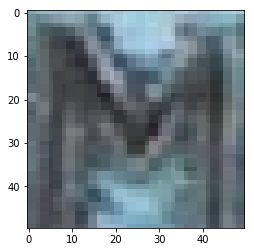

In [10]:
img_path = "/home/apofeo/Documents/detect_result/1_0.png"
# img_path = "/home/apofeo/Documents/clp_rotated_test/train/200/bab717de49084b2a91e3fe2d3f272db3.png"
# img_path = "/home/apofeo/Documents/clp_rotated_v7/test/148/5d98d2923894428d9dd6591d174d926e.png"
# img_path = "im_base_to_angle/rotated_5_pa/test/59/04863e7d13d4462aaaafd675eeaf3170.png"
# img_path = "/home/apofeo/Documents/Screenshot from 2019-03-20 23-39-04.png"
img = image.load_img(img_path, target_size=(50, 50))
img_sobel = ndimage.sobel(img, axis=0, mode='constant')
# img = ndimage.rotate(img, 180, reshape=True)
plt.grid(False)
plt.imshow(img)
# plt.imshow(img_sobel)

In [22]:
prediction = loaded_model.predict(prepare_1ch(img_path))
print(prediction)

[[0.0000000e+00 0.0000000e+00 3.4477170e-32 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 7.7654378e-38 0.0000000e+00 1.3453452e-07
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 3.1688696e-06
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  9.9999666e-01 0.0000000e+00]]


In [12]:
print(f'{np.argmax(prediction)} ({CATEGORIES[np.argmax(prediction)]})')

20 (У)


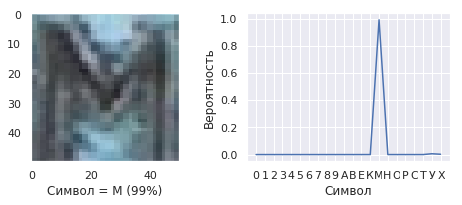

In [16]:
# grid = plt.GridSpec(1, 2, wspace=0.8, hspace=0.3)
# fig, axs = plt.subplots(1,2,figsize=(10,5))
# fig.subplots_adjust(hspace=0.4, wspace=0.5)
fig = plt.figure(figsize=(8, 6))
d = {"Символ": CATEGORIES, "Вероятность": prediction[0]}
pdnumval = pd.DataFrame(d)
plt.subplot(2, 2, 1)
plt.imshow(img)
plt.grid(False)
plt.xlabel(
        "Символ = {} ({:2.0f}%)".format(
            CATEGORIES[np.argmax(prediction)],
            100 * np.max(prediction)
        )
)
plt.subplot(2, 2, 2)
sns.set(style="darkgrid")
sns.lineplot(x="Символ", y="Вероятность", data=pdnumval)

#### Dirty imgs for test

In [13]:
filename = "trained_data/to_test/X_CLP_SYMBOLS_test_30x30.sav"
X = joblib.load(filename)

In [14]:
filename = "trained_data/to_test/Y_CLP_SYMBOLS_test_30x30.sav"
Y = joblib.load(filename)

In [15]:
filename = "trained_data/to_test/Z_CLP_SYMBOLS_test_30x30.sav"
Z = joblib.load(filename)

#### Training set (dirty imgs)

In [80]:
right_answers_list = []
wrong_answers_list = []

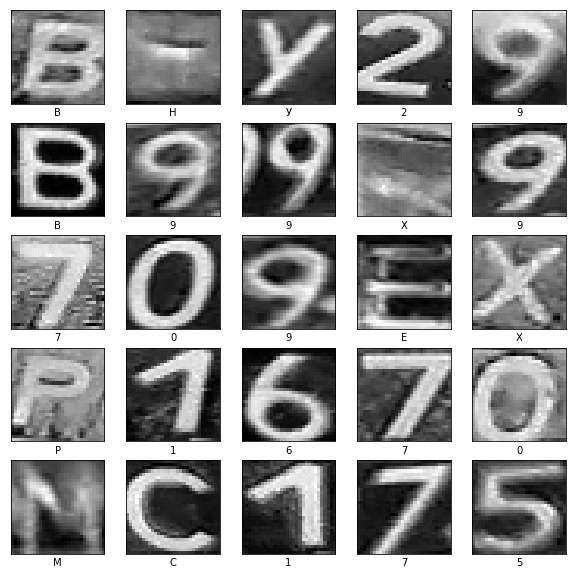

In [16]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X[i], cmap=plt.cm.binary)
    plt.xlabel(CATEGORIES[Y[i]])
plt.show()

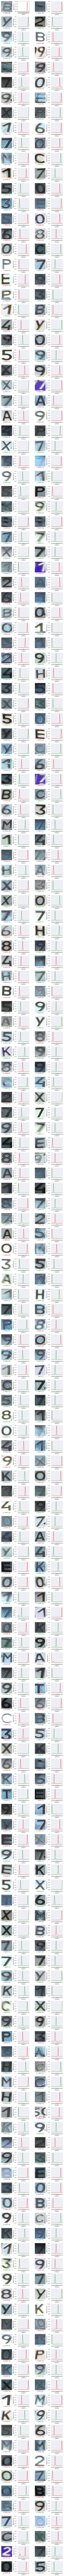

In [17]:
num_rows = 170
num_cols = 2
num_images = num_rows*num_cols
fig = plt.figure(figsize=(6*num_cols, 3*num_rows))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for idx, path in enumerate(Z[:num_images]):
    prediction = loaded_model.predict(prepare_1ch(path))
    img = image.load_img(path, target_size=(100, 100))
#     fig = plt.figure(figsize=(8, 6))
    d = {"Символ": CATEGORIES, "Вероятность": prediction[0]}
    pdnumval = pd.DataFrame(d)
    fig.add_subplot(num_rows, 2*num_cols, 2*idx+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    predicted_label = np.argmax(prediction)
    if predicted_label == Y[idx]:
        color = "green"
    else:
        color = "red"
    plt.xlabel(
            "{} {:2.0f}% ({})".format(
                CATEGORIES[predicted_label],
                100 * np.max(prediction),
                CATEGORIES[Y[idx]],
            ),
        color = color,
        fontsize = 14
    )
    fig.add_subplot(num_rows, 2*num_cols, 2*idx+2)
    sns.set(style="darkgrid")
    sns.lineplot(x="Символ", y="Вероятность", data=pdnumval, color=color)

#### Calculate accuracy score

In [28]:
model_accuracy = 0
right_answer = 0
number_of_imgs = len(Z)
for idx, path in enumerate(Z):
    prediction = loaded_model.predict(prepare_1ch(path, 30))
    predicted_label = np.argmax(prediction)
    if predicted_label == Y[idx]:
        right_answer += 1
        right_answers_list.append(Y[idx])
    else:
        wrong_answers_list.append(Y[idx])

model_accuracy = (right_answer/number_of_imgs) * 100
print(f'Right answers = {right_answer}, number of imgs = {number_of_imgs}, model accuracy = {round(model_accuracy,2)}%')

Right answers = 528, number of imgs = 673, model accuracy = 78.45%


In [53]:
symbols_frequency = dict()
counter=collections.Counter(Y)

In [39]:
print(counter)

Counter({7: 90, 9: 86, 1: 70, 0: 43, 5: 31, 21: 29, 8: 26, 4: 26, 3: 25, 12: 24, 6: 23, 18: 23, 16: 22, 11: 21, 20: 21, 10: 21, 14: 19, 13: 19, 2: 17, 15: 13, 17: 12, 19: 12})


In [34]:
print(counter.values())

dict_values([21, 13, 21, 17, 86, 29, 90, 43, 24, 12, 70, 23, 19, 23, 31, 25, 26, 26, 21, 22, 19, 12])


In [37]:
print(sorted(counter.keys()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]


In [54]:
for key in sorted(counter.keys()) :
    symbols_frequency[CATEGORIES[key]] = counter[key]

In [55]:
print(symbols_frequency)

{'0': 43, '1': 70, '2': 17, '3': 25, '4': 26, '5': 31, '6': 23, '7': 90, '8': 26, '9': 86, 'А': 21, 'В': 21, 'Е': 24, 'К': 19, 'М': 19, 'Н': 13, 'О': 22, 'Р': 12, 'С': 23, 'Т': 12, 'У': 21, 'Х': 29}


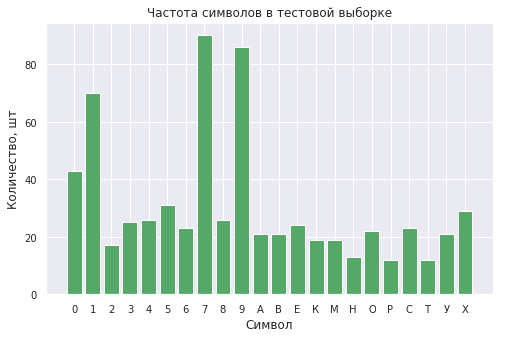

In [79]:
plt.figure(figsize=(8,5))
plt.bar(list(symbols_frequency.keys()), symbols_frequency.values(), width=0.8, color='g')
plt.title('Частота символов в тестовой выборке')
plt.xlabel('Символ')
plt.ylabel('Количество, шт')
plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

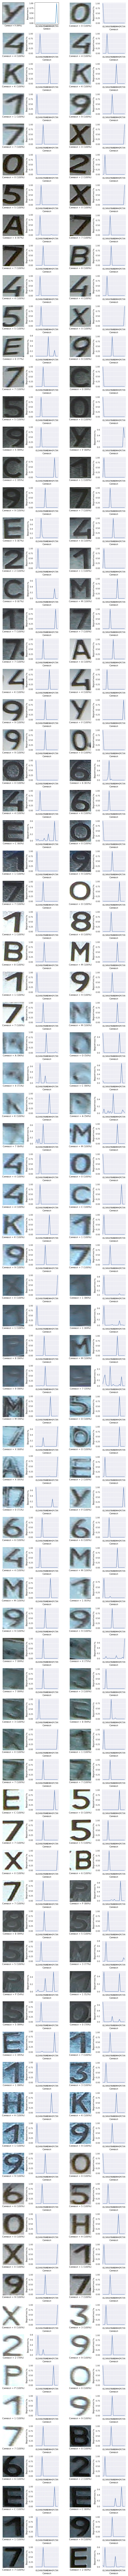

In [11]:
DATADIR = "/home/apofeo/Documents/detect_result"
num_rows = 170
num_cols = 2
num_images = num_rows*num_cols
fig = plt.figure(figsize=(6*num_cols, 3*num_rows))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for idx, path in enumerate(get_files_from_paths(DATADIR)[:num_images//2]):
    prediction = loaded_model.predict(prepare_1ch(path))
    img = image.load_img(path, target_size=(100, 100))
    d = {"Символ": CATEGORIES, "Вероятность": prediction[0]}
    pdnumval = pd.DataFrame(d)
    fig.add_subplot(num_rows, 2*num_cols, 2*idx+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    plt.xlabel(
        "Символ = {} ({:2.0f}%)".format(
            CATEGORIES[np.argmax(prediction)],
            100 * np.max(prediction)
        )
    )
    fig.add_subplot(num_rows, 2*num_cols, 2*idx+2)
    sns.set(style="darkgrid")
    sns.lineplot(x="Символ", y="Вероятность", data=pdnumval)